In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


## Необработанные данные

In [2]:
db = 'series_g.csv'
df = pd.read_csv(db, sep=";", parse_dates=['date'])
df

,date,series_g
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


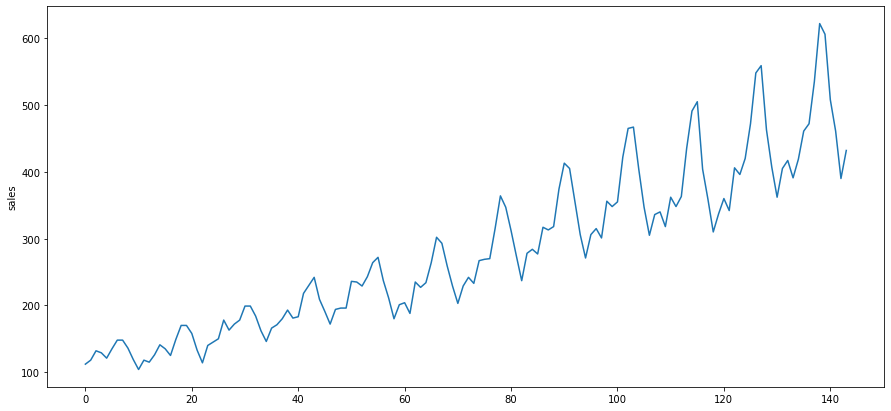

In [3]:
plt.figure(figsize(15,7))
df['series_g'].plot()
plt.ylabel('sales')
pylab.show()

In [4]:
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['series_g'])[1])

 Критерий Дики-Фуллера: p=0.991880


Оптимальный параметр преобразования Кокса- Бокса: 0.148023
 Критерий Дики-Фуллера: p=0.617162


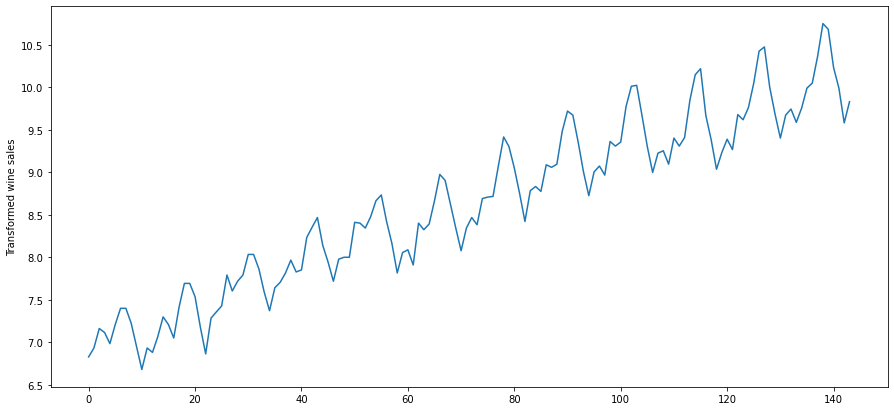

In [5]:
df['series_g'], lmbda = stats.boxcox(df['series_g'])
plt.figure(figsize(15,7))
df['series_g'].plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Кокса- Бокса: %f" % lmbda)
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['series_g'])[1])

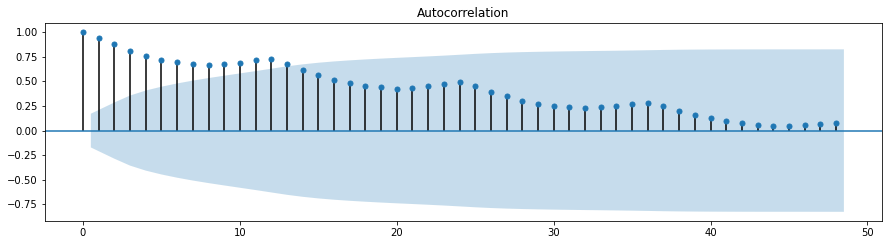

C:\Programs\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


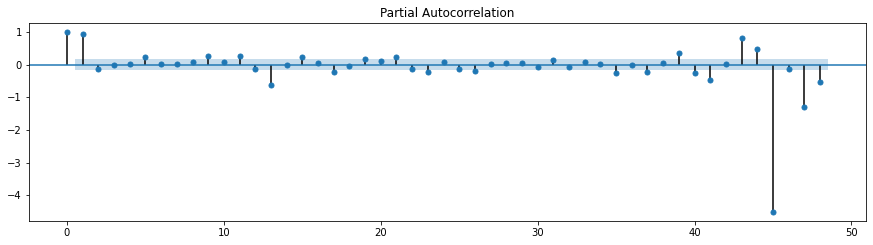

In [6]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['series_g'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['series_g'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

В автокоррекции номер последнего значимого сезонного лага Q = 4

Номер не сезонного значимого лага  q = 3

В частичной автокоррекции номер последнего значимого сезонного лага P = 4

Номер не сезонного значимого лага p = 6

In [7]:
Qs = range(0, 5)
qs = range(0, 4)
Ps = range(0, 5)
ps = range(0, 7)
D = 1
d = 1

In [8]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

700

In [9]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучаетс¤
    try:
        model=sm.tsa.statespace.SARIMAX(df['series_g'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
#     print(type(model))
    #сохран¤ем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        best_mae = model.mae
        best_mse = model.mse
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1h 28min 31s


In [12]:
print(best_model.mse)
print(best_model.mae)

0.41592978204387826
0.14038785124539183


In [13]:
import csv

writer = csv.writer(open("results.csv", 'w', newline = ''))
columns = ['ps', 'qs', 'Ps', 'Qs', 'aic']
writer.writerow(columns)
for row in results:
    arr = []
    arr.append(int(row[0][0]))
    arr.append(int(row[0][1]))
    arr.append(int(row[0][2]))
    arr.append(int(row[0][3]))
    arr.append(row[1])
    writer.writerow(arr)    

In [14]:
ndf = pd.read_csv('results.csv')
ndf = ndf.dropna()
ndf.isna().sum()

ps     0
qs     0
Ps     0
Qs     0
aic    0
dtype: int64

In [15]:
ndf['ps'] = ndf['ps'].astype(int)
ndf['Qs'] = ndf['Qs'].astype(int)
ndf

C:\Programs\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ps,qs,Ps,Qs,aic
0,0,0,0,0,-225.280531
1,0,0,0,1,-253.140760
2,0,0,0,2,-251.149185
3,0,0,0,3,-217.832836
4,0,0,0,4,-249.597653
...,...,...,...,...,...
574,5,2,4,4,-258.561449
575,5,3,0,0,-245.903881
576,5,3,0,1,-261.584005
577,5,3,0,2,-260.374137


In [16]:
print('best aic: {}, best model: {}, best param: {}'.format(best_aic, best_model, best_param))

best aic: -269.7649166392546, best model: <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000001A4D9067948>, best param: (3, 3, 0, 4)


C:\Programs\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 Критерий —Стьюдента: p=0.999730
 Критерий Дики-Фуллера: p=0.000000


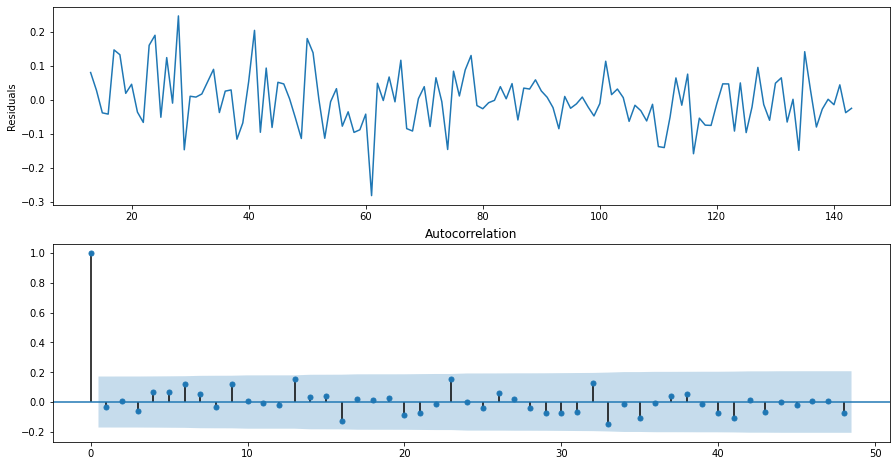

In [17]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print(" Критерий —Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

При проверке гипотез используют критерий Стьюдента, по нему можно судить о том, верно предоположение или нет.

Примерная интерпритация:

≥0,1Данные согласуются с нулевой гипотезой (H0), различия не подтверждены

#### ≥0,05Есть сомнения в истинности как нулевой (H0), так и альтернативной гипотез (H1)<0,05 Нулевая гипотеза (H0) может быть отвергнута.

≤0,01Нулевая гипотеза (H0) может быть отвергнута. Сильный аргумент

≤0,001Нулевая гипотеза (H0) наверняка не подтверждается. Очень сильный аргумент

Остатки СМЕЩЕНЫ (подтверждается критерием —Стьюдента) СТАЦИОНАРНЫ (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Тьюнга-Кокса и коррелограммой). ѕосмотрим, насколько хорошо модель описывает данные:

C:\Programs\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


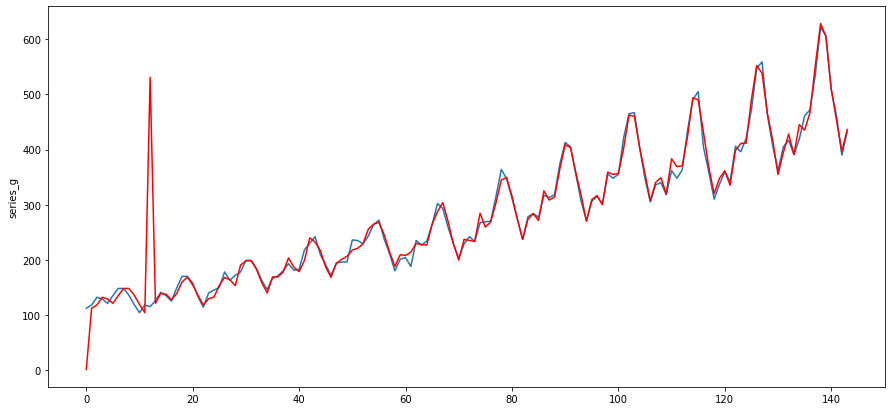

In [22]:
db = 'series_g.csv'
df = pd.read_csv(db, sep=";", parse_dates=['date'])
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df['series_g'].plot()
df.model[0:].plot(color='r')
plt.ylabel('series_g')
pylab.show()

In [23]:
df.tail()

C:\Programs\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,series_g,model
139,1960-08-01,606,605.575004
140,1960-09-01,508,510.867551
141,1960-10-01,461,452.854487
142,1960-11-01,390,396.090610
143,1960-12-01,432,436.367168


C:\Programs\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1080x504 with 0 Axes>

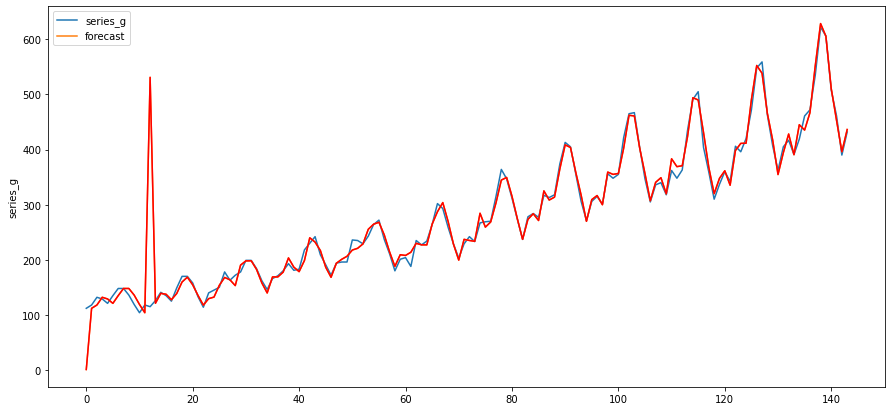

In [26]:
df2 = df[['series_g']]
date_list = [datetime.datetime.strptime("1961-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=0, end=1500), lmbda)

plt.figure(figsize(15,7))
df2.plot()
df2.forecast.plot(color='r')
plt.ylabel('series_g')
pylab.show()

Выглядит хорошо, дисперсия не увеличивается, есть дельта, но прогнозу не мешает. Остатки стационарны, значит дельта в прогнозе не мешает отслеживанию реальных данных.